In [0]:
%run /4-37am/AB_tests_framework/ab_tests_related_functions

Input configurations for the sample size calculations

In [0]:
# NOTE that you can choose only 1 metric type and 1 metric within it to calculate needed Sample Size

# if your success metric is continuous one choose flag = TRUE and write name of the column for this metric from your query
continuous_metric_flag = True
continuous_metric_name = 'gmv' 

# if your success metric is proportion metrc one choose flag = TRUE and write name of the column for these metrics in numerator:denumerator format from your query
proportions_metric_flag = False
proportions_columns = {'over100_customers':'all_customers'} # names of metrics from sql query that you want to use for proportion metrics in numerator:denumerator format. Note that values per user must be binary 0 or 1. 

# if your success metric is ratio metrc one choose flag = TRUE and write name of the column for these metrics in numerator:denumerator format from your query
ratio_metric_flag = False 
ratio_columns = {'gmv':'ob10w'} # names of metrics from sql query that you want to use for ratio metrics in numerator:denumerator format. 

max_weeks = 13 # choose max number of weeeks that you are ready to run your AB test
treatment_share_percent = 0.1 # choose share of treatment group from all customers. E.g if you roll-out treatment group on 10% of customers in DE then filter your query with 'DE' filter and choose treatment_share_percent = 0.1  
mde=0.005 # choose MDE that you want to detect in your AB test

min_weeks_with_significance = 3 # Choose number of weeks in-a-row with pvalue<0.05. The more you choose the more conservative and reliable results you will get but more weeks to wait for AB test results you will need. We suggest to use not less than 3. 5 is already very reliable

bootstrap_iterations=800 # (optional) if you want faster calculations you can reduce this number but you will lose in precision. 800 is recomnded as balance between precision and speed

week= 1 ; pval= 0.4675
week= 2 ; pval= 0.3125
week= 3 ; pval= 0.2775
week= 4 ; pval= 0.215
week= 5 ; pval= 0.2225
week= 6 ; pval= 0.14
week= 7 ; pval= 0.11
week= 8 ; pval= 0.095
week= 9 ; pval= 0.1125
week= 10 ; pval= 0.095
week= 11 ; pval= 0.11
week= 12 ; pval= 0.0925
week= 13 ; pval= 0.095
13 weeks is not enough to get MDE= 0.005 with control group as 10.0 % from all audience and ~ 469782 customers

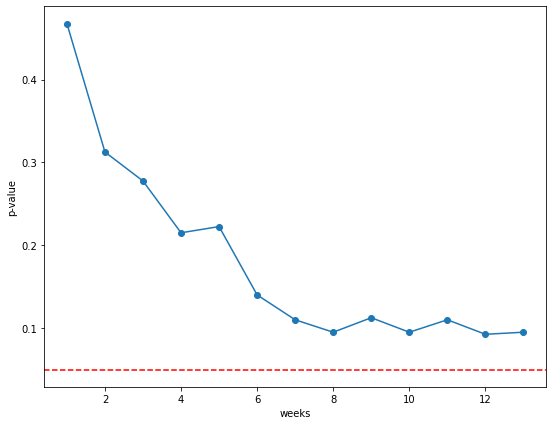

In [0]:
sample_share_percent=str(treatment_share_percent)
w=0
pval_counter=0
pvals=dict()
if (continuous_metric_flag and proportions_metric_flag) or (continuous_metric_flag and ratio_metric_flag) or (proportions_metric_flag and ratio_metric_flag):
  raise ValueError('You should choose  only one metric type flag')
  
while w<max_weeks and pval_counter<min_weeks_with_significance:
  w+=1
  wk=str(w)
  
#   insert your query that results into table grouped by customer_id and contains column with needed success metric calculations. Also you have to inject WHERE clause that contains 'date between dateadd('w',-"""+wk+""",current_date-1) and current_date-1'
  query= f"""

  select
     sk_customer,
      sum(gmv_bef_return) as gmv,
      sum(total_items) as items,
      count(distinct order_number) as orders,
      sum(ob10w) as ob10w
  case when gmv>100 then 1 else 0 end as over100_customers, 1 as all_customers
  from dwh.v_sales_order o, dwh.v_sales_channel ch
  where o.sk_sales_channel=ch.sk_sales_channel
    and sk_payment_method = 3 
    and cancelation_status != 'FULL'
    and country_shop = 'DE Shop'
    and order_date::date between dateadd('w',-"""+wk+""",current_date-1) and current_date-1
  group by 1

  """
  

  pval, w, pval_counter, s_size, pvals = main_function_for_sample_size_calculations(query, mde, w, treatment_share_percent, pvals, pval_counter, proportions_columns, ratio_columns, continuous_metric_name, continuous_metric_flag, proportions_metric_flag, ratio_metric_flag)  


pvals
plt.figure(figsize=(9, 7))
plt.axhline(y = 0.05, color = 'r', linestyle = '--')
plt.xlabel('weeks')
plt.ylabel('p-value')
plt.plot(pvals.keys(), pvals.values(),'o', ls='-')
if pval_counter>=min_weeks_with_significance:
  print ('To reach MDE=',mde,'with control group as',treatment_share_percent*100,'% from all audience, you will need ',w, 'weeks and ~',s_size,'customers')
else:
  print (max_weeks,' weeks is not enough to get MDE=',mde,' with control group as',treatment_share_percent*100,'% from all audience and ~',s_size,'customers')
  
  
  